In [7]:
from pathlib import Path 
import os
import pandas as pd
from collections import OrderedDict
import numpy as np
import sys
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import hdbscan 
import tensorboard
from sentence_transformers import SentenceTransformer

#sys.path.append("/Users/alina/Desktop/MIT/code/ADHD/item_analysis")
from src.topic_modeling import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data loading

In [8]:
data_root = Path("/Volumes/Samsung_T5/MIT/abcd/release_05/abcd-data-release-5.1")
vocab_path  = Path("/Volumes/Samsung_T5/MIT/abcd/adhd_vocab.npy")

section = "core/mental-health"
table = 'mh_p_ksads_adhd.csv'
mapping = 'ksads_adhd.csv'

data_section = Path( data_root, section)
data_path = Path(data_section, table) # path to results table  
var_mapping_path =  Path(data_root, "var_mapping", mapping) # path to mapping of variable names to questions 

abbreviation = {"mental-health" : "mp", "parent": "p", "youth": "y"}
event_names = [ "baseline_year_1_arm_1","1_year_follow_up_y_arm_1","2_year_follow_up_y_arm_1","3_year_follow_up_y_arm_1", "4_year_follow_up_y_arm_1", "4_year_follow_up_y_arm_1" ]
year = dict(zip(range(0, 6), event_names)) # asses year in the column "eventname"
#os.listdir(data_section)

In [9]:
data = pd.read_csv(data_path)
var_description = pd.read_csv(var_mapping_path)
vocab = np.load(vocab_path, allow_pickle=True)

var_names = np.array(var_description["var_name"])
questions = np.array(var_description["var_label"])
mapping = OrderedDict(zip(var_names, questions))

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_29531/3026109515.py:1: DtypeWarning: Columns (23,76,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [10]:
print(var_names[:5])
print(questions[:5])

['ksads_adhd_raw_978_p' 'ksads_adhd_raw_991_p' 'ksads_adhd_raw_990_p'
 'ksads_adhd_raw_988_p' 'ksads_adhd_raw_987_p']
['In the past two weeks, how often has your child put off or avoided doing things that were hard for him or her because they required a lot of attention?'
 'Do the problems we have just been talking about cause difficulties for your child in any of the following areas:With family'
 'Do the problems we have just been talking about cause difficulties for your child in any of the following areas:With friends'
 "In the past two weeks, how often has your child talked when he or she wasn't supposed to, or had people complain that he or she talked too much?"
 'In the past two weeks, how often has your child interrupted someone when they were talking?']


## Model specification

In [11]:
embeddings_name = "all-MiniLM-L6-v2"
sentence_embedding_model = SentenceTransformer(embeddings_name)       # load embedding
sentence_embedding_model._first_module().max_seq_length = 500 # if you want to increase, but makes it slower
print(sentence_embedding_model.max_seq_length) #default = 256

500


### Maedbh

In [12]:
# embeddings_qst = tm.get_embeddings(questions, transformer=embeddings_name) # 'distilbert-base-nli-mean-tokens'
# embeddings_vocab = tm.get_embeddings(vocab, transformer='dmis-lab/biobert-base-cased-v1.2')

In [13]:
embeddings_qst = sentence_embedding_model.encode(questions, convert_to_tensor=True,show_progress_bar=True)
embeddings_vocab = sentence_embedding_model.encode(vocab, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
similarity = cosine_similarity(embeddings_qst, embeddings_vocab)

In [15]:
umap_qst = dimensionality_reduction(embeddings_qst, n_neighbors= 3, n_components=2, metric="cosine", min_dist=0.1)
umap_vocab = dimensionality_reduction(embeddings_vocab, n_neighbors= 3, n_components=2, metric="cosine", min_dist=0.1)

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_29531/3051946335.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_qst[:, 0], umap_qst[:, 1], cmap='Spectral', s=5, label="questions")
/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_29531/3051946335.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_vocab[:, 0], umap_vocab[:, 1], cmap='Spectral', s=5, label="vocab")


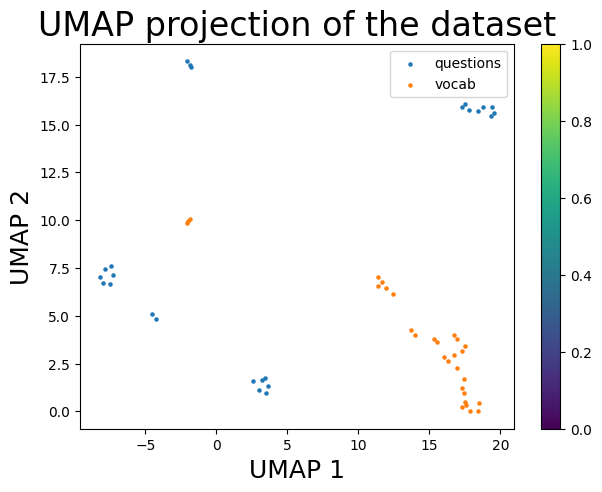

In [16]:
plt.figure(figsize=(7,5))
plt.scatter(umap_qst[:, 0], umap_qst[:, 1], cmap='Spectral', s=5, label="questions")
plt.scatter(umap_vocab[:, 0], umap_vocab[:, 1], cmap='Spectral', s=5, label="vocab")
plt.title('UMAP projection of the dataset', fontsize=24)
plt.xlabel('UMAP 1', fontsize=18)
plt.ylabel('UMAP 2', fontsize=18)
plt.colorbar()
plt.legend()
plt.show()

In [17]:

cluster_qst = hdbscan.HDBSCAN(algorithm="best", 
                          min_cluster_size=2,
                          gen_min_span_tree = True,
                          metric='euclidean',       
                          cluster_selection_method = "eom").fit(umap_qst)
cluster_vocab = hdbscan.HDBSCAN(algorithm="best", 
                          min_cluster_size=2,
                          gen_min_span_tree = True,
                          metric='euclidean',       
                          cluster_selection_method = "eom").fit(umap_vocab)

#cluster = clustering(umap_embeddings_qst, metric="manhattan", min_cluster_size=3, cluster_selection_method="leaf", gen_min_span_tree = True)

In [18]:
cluster_qst.labels_
cluster_qst.probabilities_
cluster_qst.cluster_persistence_
cluster_qst.outlier_scores_
cluster_qst.relative_validity_

0.8075888194759955

In [37]:

result = pd.DataFrame(umap_qst, columns=['x', 'y'])
result['labels'] = cluster_qst.labels_



OrderedDict([('ksads_adhd_raw_978_p',
              'In the past two weeks, how often has your child put off or avoided doing things that were hard for him or her because they required a lot of attention?'),
             ('ksads_adhd_raw_991_p',
              'Do the problems we have just been talking about cause difficulties for your child in any of the following areas:With family'),
             ('ksads_adhd_raw_990_p',
              'Do the problems we have just been talking about cause difficulties for your child in any of the following areas:With friends'),
             ('ksads_adhd_raw_988_p',
              "In the past two weeks, how often has your child talked when he or she wasn't supposed to, or had people complain that he or she talked too much?"),
             ('ksads_adhd_raw_987_p',
              'In the past two weeks, how often has your child interrupted someone when they were talking?'),
             ('ksads_adhd_raw_986_p',
              'In the past two weeks, how of

In [19]:
clustered_qst = umap_qst[np.where(cluster_qst.labels_ != -1)]
clustered_vocab = umap_vocab[np.where(cluster_vocab.labels_ != -1)]

outliers_qst = umap_qst[np.where(cluster_qst.labels_ == -1)]
outliers_vocab = umap_vocab[np.where(cluster_vocab.labels_ == -1)]

Text(0.5, 1.0, 'vocabulary')

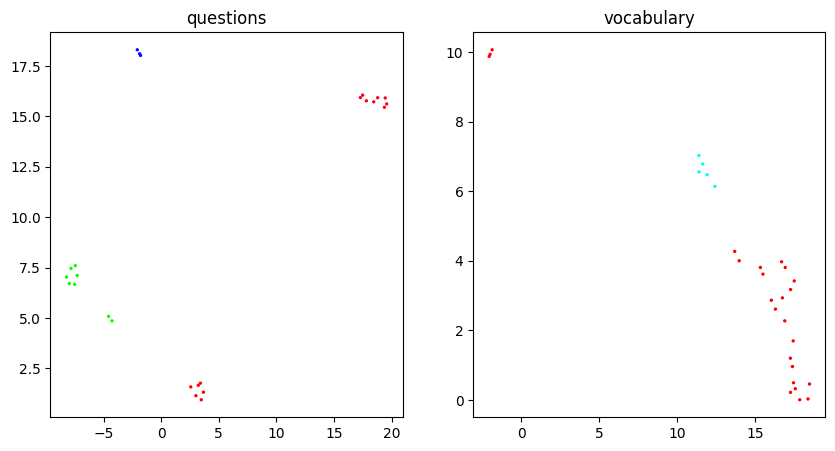

In [20]:


# Visualize clusters
fig, ax = plt.subplots(1,2, figsize=(10, 5))

#plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.1)
ax[0].scatter(clustered_qst[:,0], clustered_qst[:,1], c=cluster_qst.labels_, s=2.0, cmap='hsv_r')
ax[1].scatter(clustered_vocab[:,0], clustered_vocab[:,1], c=cluster_vocab.labels_, s=2.0, cmap='hsv_r', label= "vocabulary")

ax[0].set_title("questions")
ax[1].set_title("vocabulary")


In [22]:
import plotly.express as px


In [29]:
df_all = visualize_clusters_interactive(embeddings=embeddings_qst, 
                                        topic_data=None,
                                        hover_data=questions,
                                        cluster=cluster_qst, 
                                        n_neighbors=5,
                                        min_dist=0.3,
                                        n_components=2
                                       )

ValueError: Value of 'hover_data_0' is not the name of a column in 'data_frame'. Expected one of ['x', 'y', 'labels'] but received: In the past two weeks, how often has your child put off or avoided doing things that were hard for him or her because they required a lot of attention?